# Basin-wide elevation combo plot
---
Plot mean, total volume of depth or swe by elevation bin.

*J. Michelle Hu  
University of Utah  
May 2025* 

In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyproj
import geopandas as gpd
import xarray as xr
import rioxarray
# import hvplot.xarray

from pathlib import PurePath

sys.path.append('/uufs/chpc.utah.edu/common/home/u6058223/git_dirs/env/')
import helpers as h

sys.path.append('/uufs/chpc.utah.edu/common/home/u6058223/git_dirs/ucrb-isnobal/scripts/')
import processing as proc

import plot_spatial_comparison as psc

from rasterio.enums import Resampling
import seaborn as sns
sns.set_palette('icefire')

In [2]:
# Turn off warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Set basin and WY order
basins = ['blue', 'animas', 'yampa']
# basins = ['yampa', 'animas', 'blue']
WYs = [2021, 2022, 2023, 2024]

In [4]:
# Load the csvs that are output from plot_spatial.py
workdir = '/uufs/chpc.utah.edu/common/home/skiles-group3/jmhu/figures/spatial'
var = 'depth'
csv_fns = h.fn_list(workdir, f'*{var}*.csv')

# pull basin and wy from csv fn
basin_wy_names = [f'{PurePath(csv).stem.split("_terrain_")[0]}_{PurePath(csv).stem.split("_terrain_")[1].split("_")[0]}' for csv in csv_fns]
dt_names = [PurePath(csv).stem.split(f'_{var}')[0].split("_")[-1] for csv in csv_fns]
basin_wy_names = [PurePath(csv).stem.split(f'_{var}')[0] for csv in csv_fns]
basin_wy_names

['animas_terrain_wy2021_20210419',
 'animas_terrain_wy2021_20210516',
 'blue_terrain_wy2021_20210418',
 'blue_terrain_wy2021_20210524',
 'blue_terrain_wy2022_20220419',
 'blue_terrain_wy2022_20220526',
 'blue_terrain_wy2023_20230416',
 'blue_terrain_wy2023_20230529',
 'blue_terrain_wy2024_20240425',
 'blue_terrain_wy2024_20240605',
 'yampa_terrain_wy2024_20240411',
 'yampa_terrain_wy2024_20240528']

In [5]:
# Load up the csvs and construct a giant dataframe
df_list = [pd.read_csv(csv) for csv in csv_fns]

# Add the basin_wy_name as the first header row for all columns in the df
# for df, dt_name, basin_wy_name in zip(df_list, dt_names, basin_wy_names):
#     df.columns = pd.MultiIndex.from_product([[short_filename], df.columns])
for df, basin_wy_name in zip(df_list, basin_wy_names):
    df.columns = pd.MultiIndex.from_product([[basin_wy_name], df.columns])


# Now merge it all together
big_df = pd.concat(df_list, axis=1)
big_df

animas_terrain_wy2021_20210419                                    \
          low_thresh_elevation_m cumulative_rel_area total_area_m2   
0                           1941            1.000000     219150000   
1                           2175            0.945680     482940000   
2                           2408            0.825974     384330000   
3                           2642            0.730711     527680000   
4                           2876            0.599916     605820000   
5                           3109            0.449752     593090000   
6                           3343            0.302744     531260000   
7                           3576            0.171061     451610000   
8                           3810            0.059122     225780000   
9                           4043            0.003158      12730000   

                                                        \
  mean_elevation_m  elev_range_m Baseline_mean_depth_m   
0           2058.0  (1941, 2175)              0.000139   
1           2291.5  (2175, 2408)              0.026592   
2           2525.0  (2408, 2642)              0.123153   
3           2759.0  (2642, 2876)              0.252021   
4           2992.5  (2876, 3109)              0.467357   
5           3226.0  (3109, 3343)              0.764178   
6           3459.5  (3343, 3576)              1.123326   
7           3693.0  (3576, 3810)              1.358104   
8           3926.5  (3810, 4043)              1.488158   
9           4160.0  (4043, 4277)              1.508933   

                                                                              \
  HRRR-SPIReS_mean_depth_m NWM_mean_depth_m UA_mean_depth_m ASO_mean_depth_m   
0                 0.000000         0.000000        0.000000         0.000000   
1                 0.000000         0.003410        0.000398         0.000672   
2                 0.000268         0.033805        0.013628         0.004738   
3                 0.009056         0.105740        0.101929         0.024711   
4                 0.056375         0.314982        0.330564         0.130833   
5                 0.269205         0.640005        0.650626         0.464583   
6                 0.761341         0.891361        1.002998         0.787665   
7                 1.397691         1.038465        1.363922         1.094472   
8                 1.632216         1.115234        1.641007         1.148018   
9                 1.658764         1.085705        1.779511         0.860865   

   ... yampa_terrain_wy2024_20240528                                      \
   ...              mean_elevation_m  elev_range_m Baseline_mean_depth_m   
0  ...                        1949.0  (1854, 2044)              0.000000   
1  ...                        2139.5  (2044, 2235)              0.002969   
2  ...                        2330.0  (2235, 2425)              0.026804   
3  ...                        2520.0  (2425, 2615)              0.117392   
4  ...                        2710.0  (2615, 2805)              0.388756   
5  ...                        2900.0  (2805, 2995)              0.785587   
6  ...                        3090.0  (2995, 3185)              1.134329   
7  ...                        3280.0  (3185, 3375)              1.448250   
8  ...                        3470.0  (3375, 3565)              1.521533   
9  ...                        3660.0  (3565, 3755)              1.604640   

                                                             \
  HRRR-SPIReS_mean_depth_m UA_mean_depth_m ASO_mean_depth_m   
0                 0.000000        0.000000     6.601448e-09   
1                 0.000000        0.000000     5.837669e-06   
2                 0.000001        0.000000     2.232568e-04   
3                 0.000940        0.000277     1.116448e-02   
4                 0.024189        0.047286     1.541859e-01   
5                 0.101023        0.395333     6.145789e-01   
6                 0.274428        0.890238     1.173066e+00   
7                 0.724

In [6]:
# Plot the full 12 water years
len(csv_fns)

12

In [7]:
# set the color palette and color of markers and lines for plotting
cmap = sns.color_palette('icefire')
markerstyles=['d', 'o', 'x',  'v', 's']
colors = cmap[:len(markerstyles)]
# Base the cmap and the marker off of the diff_dict keys
baselinecolor, hscolor, nwmcolor, uacolor, asocolor = colors
plotting_dict = {'Baseline': ['d', baselinecolor],
                    'HRRR-SPIReS': ['o', hscolor],
                    'NWM': ['x', nwmcolor],
                    'UA': ['v', uacolor],
                    'ASO': ['s', asocolor]}

In [8]:
def extract_elev_var(df, elevname='mean_elevation_m', varname='mean_depth_m'):
    mean_elev = df[elevname]
    colnames = [col for col in df.columns if varname in col]
    sub_df = df[colnames]
    return mean_elev, sub_df

In [9]:
SMALL_SIZE = 11
SMEDIUM_SIZE = 13
MEDIUM_SIZE = 14
BIGGER_SIZE = 24
BIGGEST_SIZE = 28

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGEST_SIZE)  # fontsize of the figure title

animas 2022 1 2
animas 2023 2 2
yampa 2022 1 2
yampa 2023 2 2


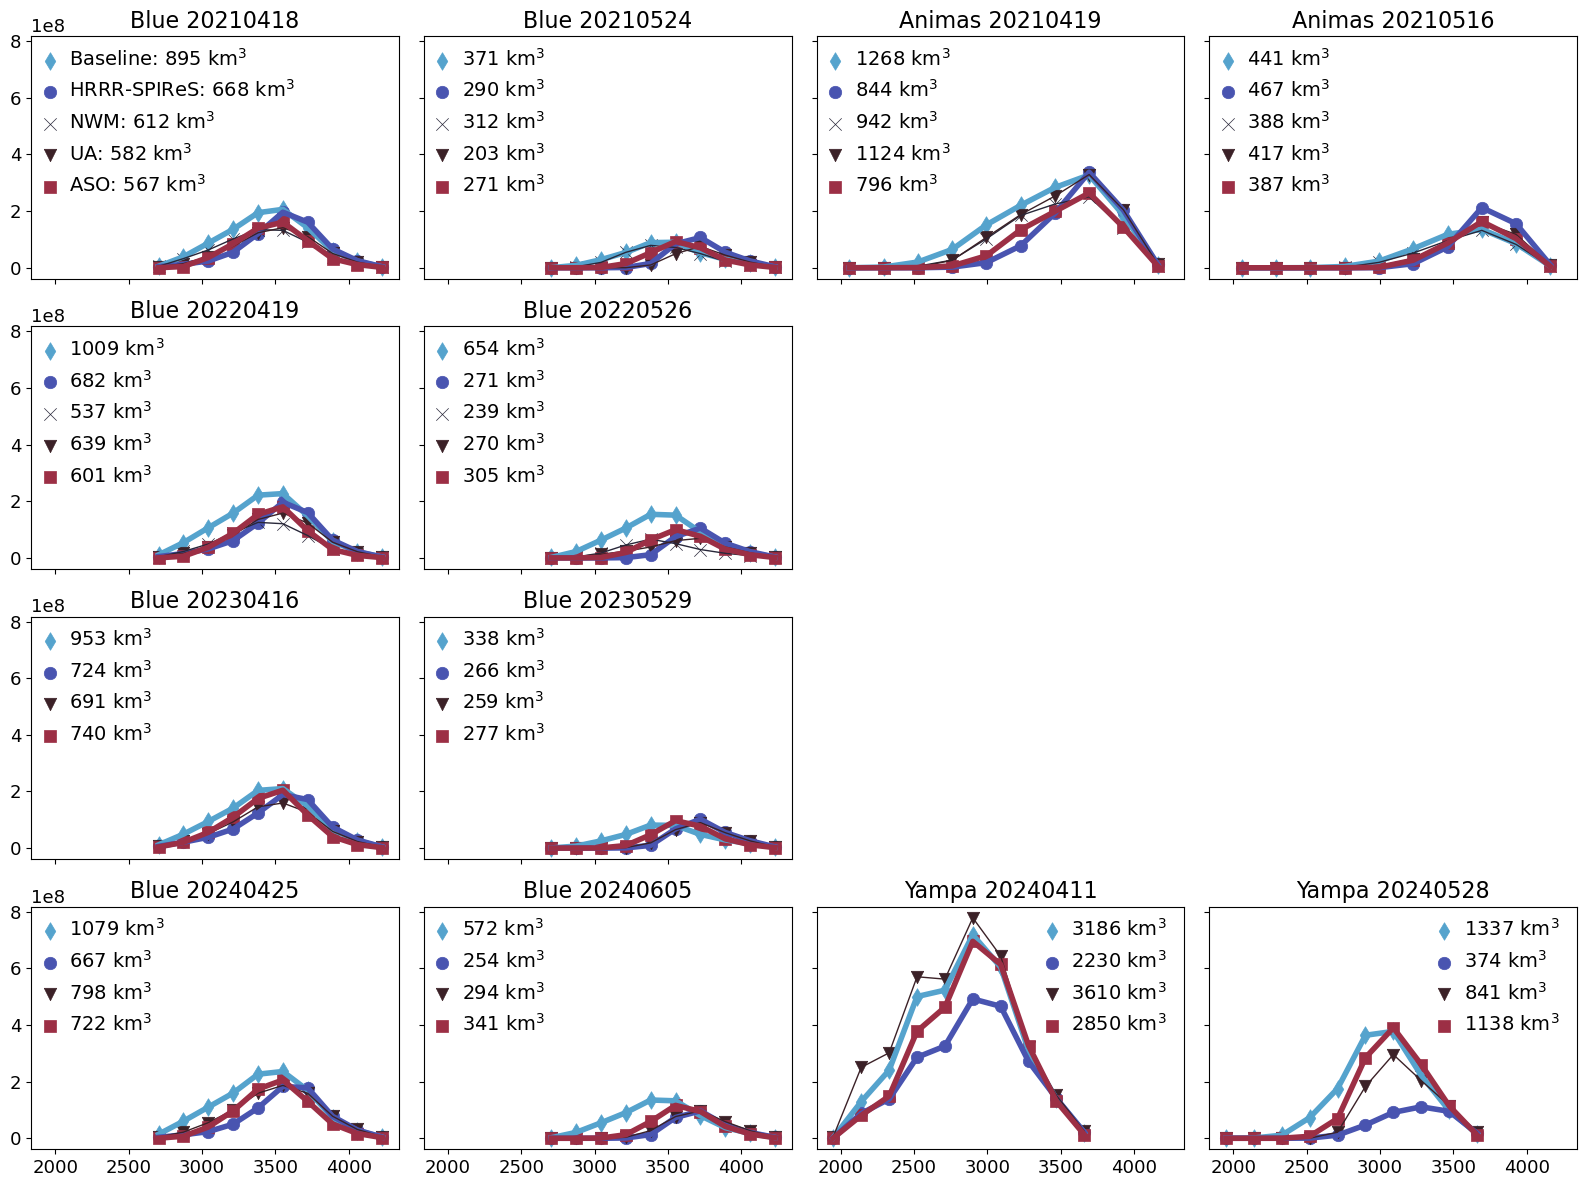

In [10]:
nrows = len(WYs)
ncols = 4
varname = 'total_volume'

# This would be the length of basins multiplied by 2 for the early and late season ASO collections
# but Animas and Yampa only have one year of collection and I am combining those columns

fig, axa = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 3*nrows), sharex=True, sharey=True)
for basin in basins:
    if basin == 'blue':
        start_bdx = 0
    else:
        start_bdx = 2
    for jdx, wy in enumerate(WYs):
        # Pull the basin water year data by column nam e
        select_columns = [col for col in big_df.columns.get_level_values(0) if basin in col ]
        select_columns = [col for col in select_columns if str(wy) in col ]
        # Remove duplicates, but maintain order
        basin_wy_dates = list(dict.fromkeys(select_columns))
        # Turn off axes where there is no ASO data (and thus, basin data)
        if (basin == 'animas' or basin == 'yampa') and (wy == 2022 or wy == 2023):
            print(basin, wy, jdx, start_bdx)
            # Turn off the axis
            ax =  axa[jdx, start_bdx]
            ax.axis('off')
            ax =  axa[jdx, start_bdx + 1]
            ax.axis('off')
        else:
            # Get the basin water year data
            basin_wy_df = big_df[basin_wy_dates]
            for ddx, basin_wy_date in enumerate(basin_wy_dates):
                ax = axa[jdx, start_bdx + ddx]
                # shorten the name to just the dt
                dt = basin_wy_date.split('_')[-1]
                ax.set_title(f'{basin.capitalize()} {dt}', fontsize=16)
                # Extract the variable data
                mean_elevs, sub_df = extract_elev_var(df=basin_wy_df[basin_wy_date], varname=varname)

                # Plot the data
                for kdx, colname in enumerate(sub_df.columns):
                    k = colname.split('_')[0]
                    coldata = sub_df[colname]
                    # Thicken lines if iSnobal run or ASO run
                    if k == 'Baseline' or k == 'ASO' or k == 'HRRR-SPIReS':
                        lw = 4
                    else:
                        lw = 1
                    if 'total_volume' in varname:
                        if start_bdx + ddx == 0 and jdx == 0:
                            label = f'{k}: {np.nansum(coldata)/1e6:.0f} km$^{3}$'
                        else:
                            label = f'{np.nansum(coldata)/1e6:.0f} km$^{3}$'
                    elif 'depth' in varname:
                        if start_bdx + ddx == 0 and jdx == 0:
                            label = f'{k}: {np.nanmean(coldata):.2f} m'
                        else:
                            label = f'{np.nanmean(coldata):.2f} m'
                    ax.scatter(mean_elevs, coldata, marker=plotting_dict[k][0], s=80, linewidths=0.5, color=plotting_dict[k][1],
                                    label=label)
                    ax.plot(mean_elevs, coldata, color=plotting_dict[k][1], lw=lw)
                if basin == 'yampa' and wy == 2024 and varname == 'total_volume':
                    leg = ax.legend(bbox_to_anchor=(1, 1.025), loc='upper right', frameon=False, handletextpad=0.01)
                else:
                    # Decrease spacing between marker in legend and label
                    leg = ax.legend(bbox_to_anchor=(-0.05, 1.025), loc='upper left', frameon=False, handletextpad=0.01)
            # ax.set_ylim(0, 4.5e6)
    plt.tight_layout()

# Allow for different ylims based on circumstance

animas 2022 1 2
animas 2023 2 2
yampa 2022 1 2
yampa 2023 2 2


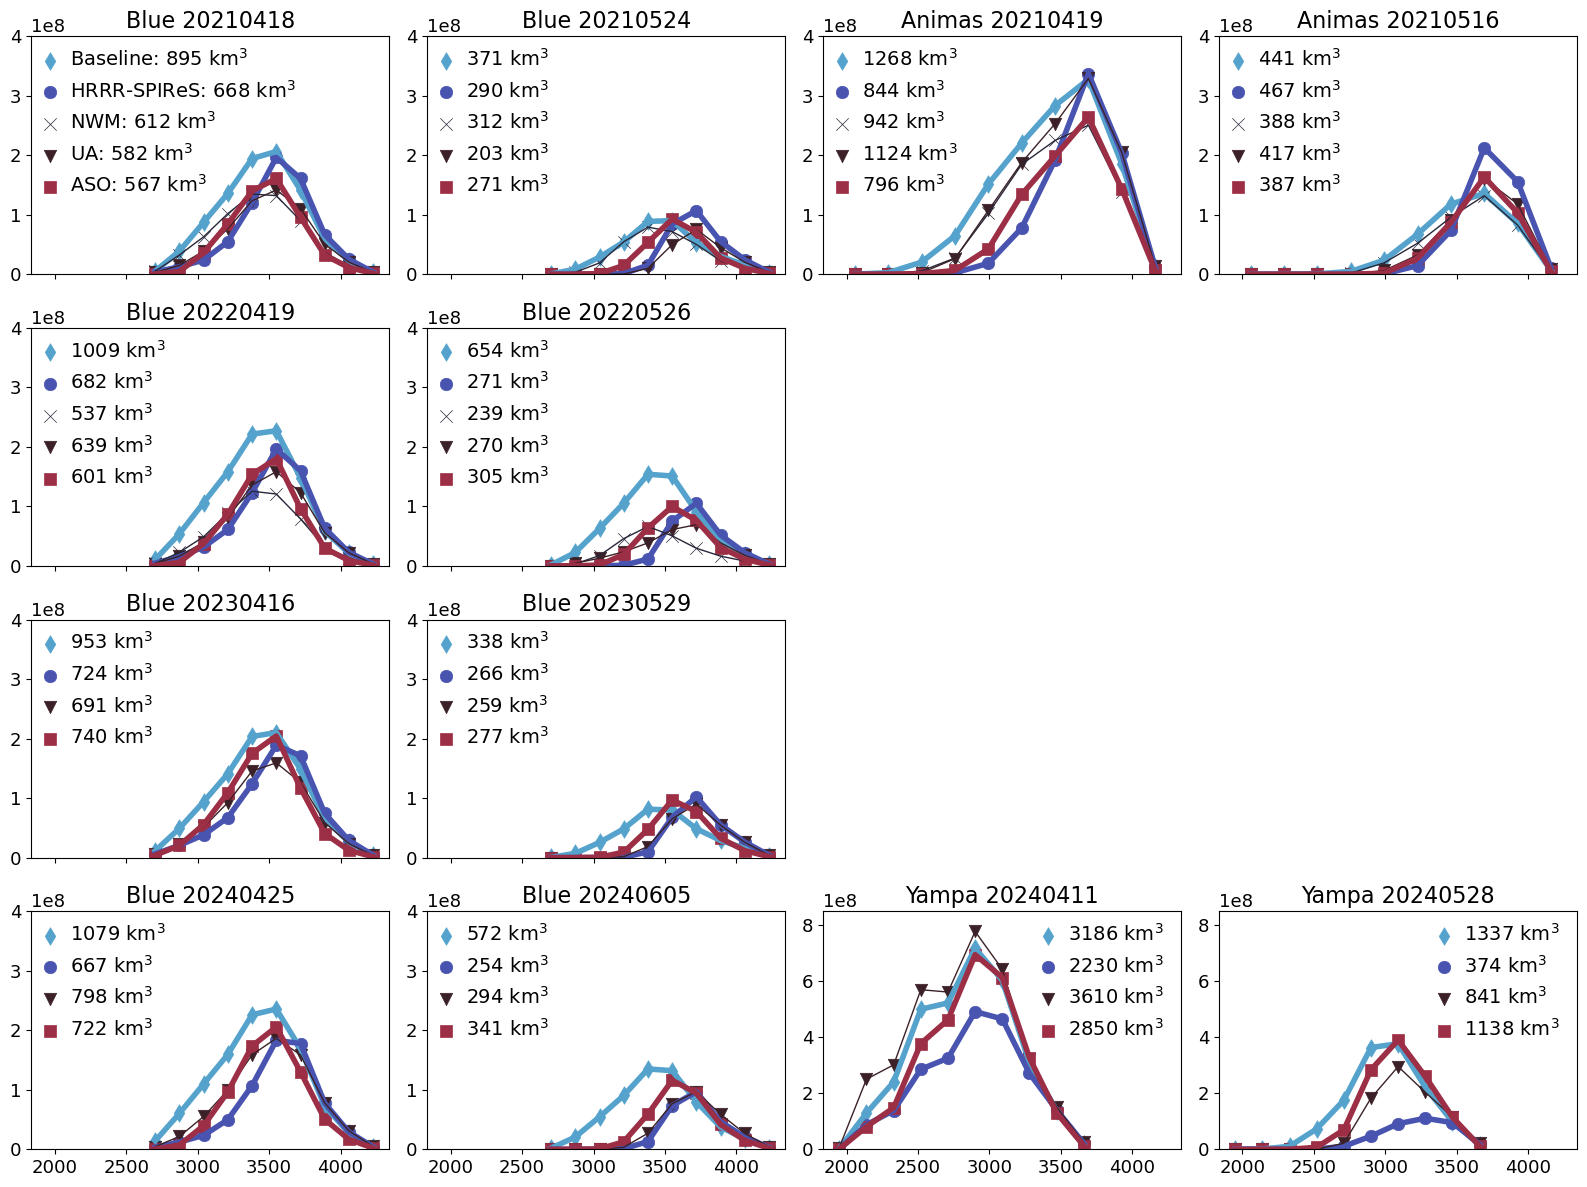

In [11]:
varname = 'total_volume'
fig, axa = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 3*nrows), sharex=True)
for basin in basins:
    if basin == 'blue':
        start_bdx = 0
    else:
        start_bdx = 2
    for jdx, wy in enumerate(WYs):
        # Pull the basin water year data by column nam e
        select_columns = [col for col in big_df.columns.get_level_values(0) if basin in col ]
        select_columns = [col for col in select_columns if str(wy) in col ]
        # Remove duplicates, but maintain order
        basin_wy_dates = list(dict.fromkeys(select_columns))
        # Turn off axes where there is no ASO data (and thus, basin data)
        if (basin == 'animas' or basin == 'yampa') and (wy == 2022 or wy == 2023):# Desired bin width
            print(basin, wy, jdx, start_bdx)
            # Turn off the axis
            ax =  axa[jdx, start_bdx]
            ax.axis('off')
            ax =  axa[jdx, start_bdx + 1]
            ax.axis('off')
        else:
            # Get the basin water year data
            basin_wy_df = big_df[basin_wy_dates]
            for ddx, basin_wy_date in enumerate(basin_wy_dates):
                ax = axa[jdx, start_bdx + ddx]
                # shorten the name to just the dt
                dt = basin_wy_date.split('_')[-1]
                ax.set_title(f'{basin.capitalize()} {dt}', fontsize=16)
                # Extract the variable data
                mean_elevs, sub_df = extract_elev_var(df=basin_wy_df[basin_wy_date], varname=varname)

                # Plot the data
                for kdx, colname in enumerate(sub_df.columns):
                    k = colname.split('_')[0]
                    coldata = sub_df[colname]
                    # Thicken lines if iSnobal run or ASO run
                    if k == 'Baseline' or k == 'ASO' or k == 'HRRR-SPIReS':
                        lw = 4
                    else:
                        lw = 1
                    if 'total_volume' in varname:
                        if start_bdx + ddx == 0 and jdx == 0:
                            label = f'{k}: {np.nansum(coldata)/1e6:.0f} km$^{3}$'
                        else:
                            label = f'{np.nansum(coldata)/1e6:.0f} km$^{3}$'
                    elif 'depth' in varname:
                        if start_bdx + ddx == 0 and jdx == 0:
                            label = f'{k}: {np.nanmean(coldata):.2f} m'
                        else:
                            label = f'{np.nanmean(coldata):.2f} m'
                    ax.scatter(mean_elevs, coldata, marker=plotting_dict[k][0], s=80, linewidths=0.5, color=plotting_dict[k][1],
                                    label=label)
                    ax.plot(mean_elevs, coldata, color=plotting_dict[k][1], lw=lw)
                if basin == 'yampa' and wy == 2024 and varname == 'total_volume':
                    leg = ax.legend(bbox_to_anchor=(1, 1.025), loc='upper right', frameon=False, handletextpad=0.01)
                    ax.set_ylim(0, 8.5e8)
                else:
                    ax.set_ylim(0, 4e8)
                    leg = ax.legend(bbox_to_anchor=(-0.05, 1.025), loc='upper left', frameon=False, handletextpad=0.01)
    plt.tight_layout()